In [1]:
"""
The script demonstrates a simple example of using ART with PyTorch. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from art.attacks import UniversalPerturbation
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

from torchvision import datasets, transforms
import torch
import numpy as np
from torch.utils.data import SubsetRandomSampler

from matplotlib import pyplot as plt

import torchvision.models as models


In [2]:
np.random.seed(1)
torch.manual_seed(1)
torch.set_num_threads(4)
numberOfClasses = 2

class Net(nn.Module):
    def __init__(self, num_classes=numberOfClasses):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [4]:
# Setp 1a: define data transform
data_transform = transforms.Compose([
        #transforms.RandomRotation(30),
        transforms.Resize((224,224)),
        #transforms.RandomCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])



# Step 1: Load the dataset
breakhis = datasets.ImageFolder(root ='C:\\Users\\Florian\\Desktop\\Datensätze_ready\\BreakHis\\BreaKHis_v1\\', 
                                 transform=data_transform)


# split into train and test dataset
train_split = 0.8
dataset_size = len(breakhis) #for testing purpose set to 1000 - else set: len(trafficsign) 
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[:split], indices[split:]


#train set
dataset_loader_train = torch.utils.data.DataLoader(breakhis, sampler=SubsetRandomSampler(train_indices), batch_size=int(np.floor(train_split * dataset_size)))
dataiter = iter(dataset_loader_train)
images, labels = dataiter.next()

x_train = images.data.numpy()
y_train = np.zeros((len(labels.data.numpy()), len(breakhis.classes)))
y_train[np.arange(len(labels.data.numpy())), labels.data.numpy()] = 1

#test set
dataset_loader_test = torch.utils.data.DataLoader(breakhis, sampler=SubsetRandomSampler(test_indices), batch_size=(len(breakhis)-int(np.floor(train_split * dataset_size))))
dataiter = iter(dataset_loader_test)
images, labels = dataiter.next()
x_test = images.data.numpy()
y_test = np.zeros((len(labels.data.numpy()), len(breakhis.classes)))
y_test[np.arange(len(labels.data.numpy())), labels.data.numpy()] = 1

#filter indices to get only benign tumors to trick them all
indices = np.where(labels == 1)
x_adv = x_test[indices]
y_adv = y_test[indices]

indices = np.where(labels == 0)
x_benign = x_test[indices]
y_benign = y_test[indices]

In [5]:
# Step 2: Create the model
model = Net()

In [6]:
# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [7]:
# Step 3: Create the ART classifier

classifier = PyTorchClassifier(model=model, loss=criterion, optimizer=optimizer, input_shape=(3, 224, 224), nb_classes=numberOfClasses)

In [8]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=100)

In [9]:
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

print('Accuracy on benign test examples: {}%'.format(accuracy * 100))

Accuracy on benign test examples: 76.76056338028168%


In [ ]:
# generateEvasionLabels
#def generateEvasionLabels():
#    evasion_labels = np.zeros((len(labels.data.numpy()), len(breakhis.classes)))
#    
#    for i in range(len(evasion_labels)):
#        evasion_labels[i][1]=1
#    return evasion_labels

In [70]:
# Step 6: Generate adversarial test examples
#attack = FastGradientMethod(classifier=classifier, eps=0.2)

#dictForAttacker ={
#    "targeted": True
#    #"theta": 0.3
#}
#, attacker_params=dictForAttacker

#delta = desired accuracy on perturbed samples
attack = UniversalPerturbation(classifier, attacker="deepfool", delta=0.25, max_iter=100, eps=45, norm=2)
#attack = UniversalPerturbation(classifier, attacker="newtonfool", delta=0.25, max_iter=100, eps=1000, norm=2)

x_test_adv = attack.generate(x=x_adv)

iteration: 0
0.09933774834437085
iteration: 1
0.31125827814569534
iteration: 2
0.08609271523178808
iteration: 3
0.5165562913907285
iteration: 4
0.543046357615894
iteration: 5
0.17218543046357615
iteration: 6
0.5099337748344371
iteration: 7
0.6887417218543046
iteration: 8
0.5761589403973509
iteration: 9
0.15894039735099338
iteration: 10
0.5960264900662252
iteration: 11
0.6821192052980133
iteration: 12
0.7947019867549668


In [71]:
# Step 7: Test adversarial samples
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_adv, axis=1)) / len(y_adv)
print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))

Accuracy on adversarial test examples: 10.596026490066226%


In [72]:
# Step 7: Test benign samples
predictions = classifier.predict(x_benign)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_benign, axis=1)) / len(y_benign)
print('Accuracy on benign test examples: {}%'.format(accuracy * 100))

Accuracy on benign test examples: 62.40601503759399%


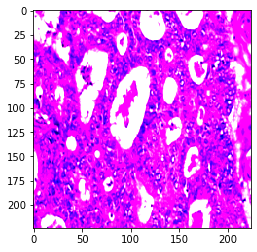

In [73]:
plt.imshow(x_adv[1].transpose((1, 2, 0)))
plt.show()

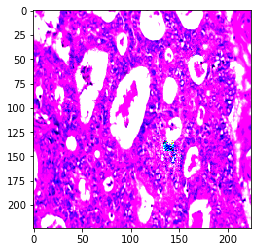

In [74]:
plt.imshow(x_test_adv[1].transpose((1, 2, 0)))
plt.show()

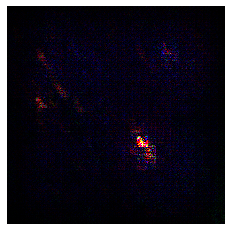

In [93]:
pixelpattern = x_adv[2].transpose((1, 2, 0))-x_test_adv[2].transpose((1, 2, 0))
plt.axis('off')
plt.imshow(pixelpattern)
plt.savefig('test.png',bbox_inches='tight', pad_inches = 0)

In [76]:
x_adv[1].transpose((1, 2, 0))-x_test_adv[1].transpose((1, 2, 0)) == x_adv[2].transpose((1, 2, 0))-x_test_adv[2].transpose((1, 2, 0))

array([[[ True,  True, False],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True, False,  True],
        [False,  True,  True]],

       [[ True, False,  True],
        [False,  True, False],
        [ True,  True, False],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [False,  True,  True]],

       [[ True,  True,  True],
        [ True, False, False],
        [ True,  True,  True],
        ...,
        [ True, False,  True],
        [ True,  True,  True],
        [ True, False, False]],

       ...,

       [[ True,  True,  True],
        [False,  True,  True],
        [ True, False,  True],
        ...,
        [False,  True, False],
        [ True,  True,  True],
        [ True,  True, False]],

       [[ True,  True,  True],
        [ True, False,  True],
        [False, False,  True],
        ...,
        [ True, False,  True],
        [ True,  True, False],
        [ True,

In [26]:
x_adv[2].transpose((1, 2, 0))-x_test_adv[2].transpose((1, 2, 0))

array([[[-1.3273954e-03, -1.6500950e-03, -8.6128712e-04],
        [-3.4550428e-03, -3.7837029e-04, -9.6082687e-04],
        [-1.5220642e-03,  1.8081665e-03,  1.6212463e-04],
        ...,
        [-1.3877153e-03,  1.6414821e-03,  4.6467781e-04],
        [-6.9665909e-04, -4.4655800e-04,  5.5038929e-04],
        [ 6.3812733e-04,  1.0845810e-03, -1.2407303e-03]],

       [[ 1.1724234e-03, -1.0012388e-03, -5.0783157e-05],
        [-2.2134781e-03, -6.4945221e-04,  1.1324883e-03],
        [-2.0980835e-04, -4.2080879e-04,  1.4662743e-04],
        ...,
        [-1.0375977e-03,  5.2431226e-04,  2.9528141e-04],
        [-1.0766983e-03, -7.0583820e-04, -1.6462803e-04],
        [-4.6372414e-04,  4.8911572e-04,  5.4228306e-04]],

       [[-1.7492771e-03, -1.1634827e-04, -2.6533604e-03],
        [ 1.6465187e-03, -3.7014484e-04, -1.9383430e-03],
        [-3.2047033e-03, -2.9745102e-03,  5.2011013e-04],
        ...,
        [-2.1167994e-03,  1.0127723e-03, -7.9143047e-04],
        [ 1.9252300e-04, -5.5

In [94]:
#Rescale to 0-255 and convert to uint8
rescaled = (255.0 / pixelpattern.max() * (pixelpattern - pixelpattern.min())).astype(np.uint8)
im = Image.fromarray(rescaled)
im.save('test1.png')